In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
df = pd.read_csv('penguins.csv')

print(df.head())
print("\n")
print(df.info())
print("\nNumber of rows and columns:")
print(df.shape)

   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
3               NaN              NaN                NaN          NaN     NaN
4              36.7             19.3              193.0       3450.0  FEMALE


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB
None

Number of rows and columns:
(344, 5)


In [4]:
# The culmen is the beak lol

# Checking and missing NaN values
missing_values = df.isnull().sum()
missing_percentage = 100 * df.isnull().sum() / len(df)
missing_table = pd.concat([missing_values, missing_percentage], axis=1, 
														keys=['Missing Count', 'Missing Percentage (%)'])

print(missing_table)


                   Missing Count  Missing Percentage (%)
culmen_length_mm               2                0.581395
culmen_depth_mm                2                0.581395
flipper_length_mm              2                0.581395
body_mass_g                    2                0.581395
sex                            9                2.616279


In [5]:
# Explicitly checking for blank values
blank_values = (df == '').sum()

# Explicitly checking for NaN values
nan_values = df.isna().sum()

print(pd.DataFrame({'Blank': blank_values, 'NaN': nan_values}))

                   Blank  NaN
culmen_length_mm       0    2
culmen_depth_mm        0    2
flipper_length_mm      0    2
body_mass_g            0    2
sex                    0    9


In [6]:
# Missing values are a really small percentage, just checking the skewness of the numerical columns
# Check how close the values are to 0

columns_to_check = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
print("Skewness of columns:")
print(df[columns_to_check].skew())

Skewness of columns:
culmen_length_mm      0.053118
culmen_depth_mm      -0.143465
flipper_length_mm    18.273303
body_mass_g           0.470329
dtype: float64


In [7]:
print(df['flipper_length_mm'].describe())

# Flipper length can't be negative.
# Max value is also too large.
# Mean significantly higher than median (50%), strong skew as a result [(Mean-Median)/Median] * 100% 

# Coefficient of Variation = (sd/Mean) * 100 ≈ 121.7% (high variability)
# IQR too 75% - 25% = (small value vs the overall range of data = presence of extreme outliers)

count     342.000000
mean      214.014620
std       260.558057
min      -132.000000
25%       190.000000
50%       197.000000
75%       213.750000
max      5000.000000
Name: flipper_length_mm, dtype: float64


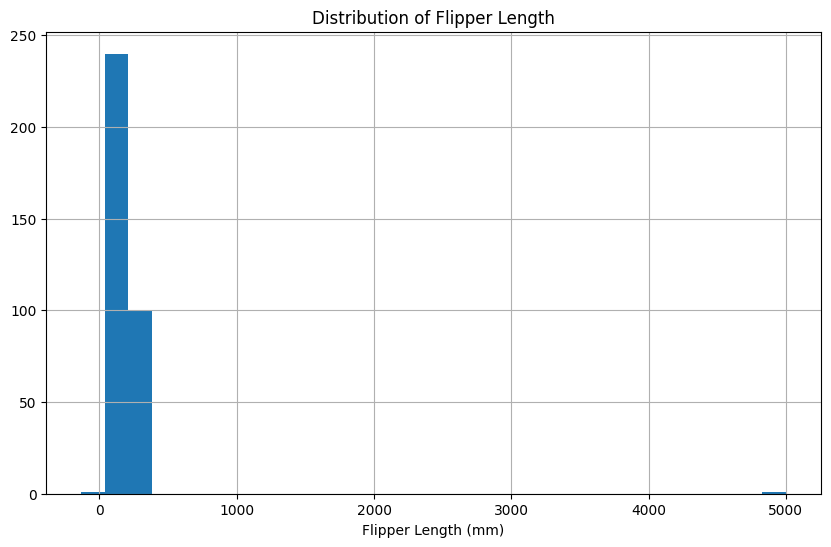

In [8]:
# Visualizing the distribution
# Choice of figsize and bins

plt.figure(figsize=(10,6))
df['flipper_length_mm'].hist(bins=30)
plt.title('Distribution of Flipper Length')
plt.xlabel('Flipper Length (mm)')
plt.xlabel('Flipper Length (mm)')
plt.show()

In [9]:
print(df.columns)

Index(['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'sex'],
      dtype='object')


In [10]:
# Removing the extreme outliers first before imputing NaN values
# Testing both z_scores and iqr outliers
def detect_flipper_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return z_scores > threshold

def detect_flipper_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

flipper_zscore = detect_flipper_zscore(df['flipper_length_mm'])
flipper_iqr = detect_flipper_iqr(df['flipper_length_mm'])


print("Outliers detected with Z-score method:")
outlier_count = flipper_zscore.sum()
print(f"Flipper length (mm): {outlier_count} outliers ({outlier_count/len(df)*100:.2f}%)")

print("\nOutliers detected with IQR method")
outlier_count = flipper_iqr.sum()
print(f"Flipper length (mm): {outlier_count} outliers ({outlier_count/len(df)*100:.2f}%)")

Outliers detected with Z-score method:
Flipper length (mm): 0 outliers (0.00%)

Outliers detected with IQR method
Flipper length (mm): 2 outliers (0.58%)


In [11]:
# Since little number of outliers, finding out the specific outlier values
print("Outlier values  (IQR):")
print(df[flipper_iqr]['flipper_length_mm'])

print("\nUnique values in flipper_length_mm:")
print(f"{df['flipper_length_mm'].unique()}")

Outlier values  (IQR):
9     5000.0
14    -132.0
Name: flipper_length_mm, dtype: float64

Unique values in flipper_length_mm:
[ 181.  186.  195.   nan  193.  190. 5000.  180.  182.  191. -132.  185.
  197.  184.  194.  174.  189.  187.  183.  172.  178.  188.  196.  179.
  200.  192.  198.  202.  205.  208.  203.  199.  176.  210.  201.  212.
  206.  207.  211.  230.  218.  215.  219.  209.  214.  216.  213.  217.
  221.  222.  220.  225.  224.  231.  229.  223.  228.  226.]


In [12]:
# Checking unique values in other columns since we want to convert them all the odd ones to NaN
for column in df.columns:
    print(f"\nUnique values in {column}:")
    print(df[column].unique())


Unique values in culmen_length_mm:
[39.1 39.5 40.3  nan 36.7 39.3 38.9 39.2 34.1 42.  37.8 41.1 38.6 34.6
 36.6 38.7 42.5 34.4 46.  37.7 35.9 38.2 38.8 35.3 40.6 40.5 37.9 37.2
 40.9 36.4 42.2 37.6 39.8 36.5 40.8 36.  44.1 37.  39.6 37.5 42.3 40.1
 35.  34.5 41.4 39.  35.7 41.3 41.6 35.5 41.8 33.5 39.7 45.8 42.8 36.2
 42.1 42.9 35.1 37.3 36.3 36.9 38.3 34.  38.1 33.1 43.2 41.  45.6 42.7
 40.2 35.2 41.5 38.5 43.1 36.8 35.6 32.1 40.7 46.5 50.  51.3 45.4 52.7
 45.2 46.1 46.6 51.7 47.  52.  45.9 50.5 50.3 58.  46.4 49.2 42.4 48.5
 50.6 46.7 49.5 52.8 54.2 51.  49.7 47.5 47.6 46.9 53.5 49.  46.2 50.9
 45.5 50.8 50.1 51.5 49.8 48.1 51.4 45.7 50.7 52.2 49.3 50.2 51.9 46.8
 55.8 43.5 49.6 48.7 43.3 48.4 45.1 46.3 44.5 47.8 48.2 47.3 59.6 49.1
 42.6 44.4 44.  45.3 43.6 44.9 45.  43.8 50.4 54.3 47.7 48.6 51.1 52.5
 47.4 43.4 52.1 49.4 55.9 47.2 41.7 53.4 55.1 48.8 49.9]

Unique values in culmen_depth_mm:
[18.7 17.4 18.   nan 19.3 20.6 17.8 19.6 18.1 20.2 17.1 17.3 17.6 21.2
 21.1 19.  20.7 18.4

In [13]:
# Converting the outlier values in 'flipper_length_mm' and "." in 'sex' to NaN and then imputing 

df['flipper_length_mm'] = df['flipper_length_mm'].replace([5000.0, -132.0], np.nan)
df['sex'] = df['sex'].replace(['.'], np.nan)

numerical_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

for col in numerical_columns: 
    df[col] = df[col].fillna(df[col].median())
    
df['sex'] = df['sex'].fillna(df['sex'].mode()[0])

print(df.isnull().sum())

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


In [14]:
print(df['sex'].unique())

['MALE' 'FEMALE']


In [15]:
# Scaling the rest of the columns and encoding 'sex'
numerical_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

ohe = OneHotEncoder(sparse_output=False)
encoded_sex = ohe.fit_transform(df[['sex']])
encoded_df = pd.DataFrame(encoded_sex, columns=ohe.get_feature_names_out(['sex']))
df = pd.concat([df, encoded_df], axis=1)
df = df.drop('sex', axis=1)

print(df.info())
print("\n")
print(df.head(10))
print("\n")
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   344 non-null    float64
 1   culmen_depth_mm    344 non-null    float64
 2   flipper_length_mm  344 non-null    float64
 3   body_mass_g        344 non-null    float64
 4   sex_FEMALE         344 non-null    float64
 5   sex_MALE           344 non-null    float64
dtypes: float64(6)
memory usage: 16.2 KB
None


   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g  \
0         -0.887622         0.787289          -1.422808    -0.564625   
1         -0.814037         0.126114          -1.065496    -0.502010   
2         -0.666866         0.431272          -0.422334    -1.190773   
3          0.096581         0.075255          -0.279410    -0.188936   
4         -1.329133         1.092447          -0.565259    -0.940314   
5         -0.850829         1.75

                   culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
culmen_length_mm           1.000000        -0.235000           0.656171   
culmen_depth_mm           -0.235000         1.000000          -0.582414   
flipper_length_mm          0.656171        -0.582414           1.000000   
body_mass_g                0.594925        -0.471942           0.871885   
sex_FEMALE                -0.322871        -0.354791          -0.243311   

                   body_mass_g  sex_FEMALE  
culmen_length_mm      0.594925   -0.322871  
culmen_depth_mm      -0.471942   -0.354791  
flipper_length_mm     0.871885   -0.243311  
body_mass_g           1.000000   -0.407107  
sex_FEMALE           -0.407107    1.000000  


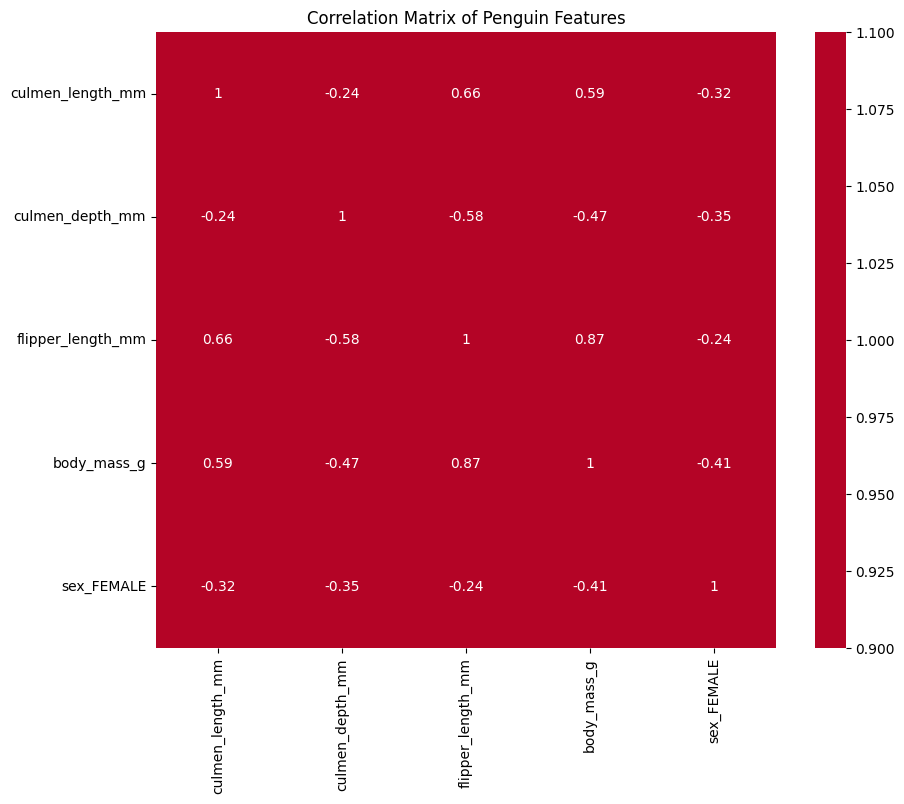

In [16]:
# Correlation analysis
# Creating a correlation matrix and heatmap visualization for it
# Dropping sex_MALE for the correlation analysis since they are perfectly negatively correlated (-1)

df_corr = df.drop('sex_MALE', axis=1)
corr_matrix = df_corr.corr()
print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=1, vmax=1, center=0)
plt.title('Correlation Matrix of Penguin Features')
plt.show()

In [ ]:
# Positive correlations
## Culmen length & Flipper length (0.66) (Penguins with larger beaks have longer flippers
## Culmen length & Body mass (0.59) (Larger penguins have longer beaks)
## Flipper length & Body mass (0.87)* (Larger penguins have longer flippers)

# Stronger Negative correlation 
## Culmen depth & Flipper length (-0.58) (Deeper beaks = Shorter flippers)
## Culmen depth & Body mass (-0.47) (Deeper beaks = Lower body mass)

# No features > 0.9: Good for avoiding multicollinearity in regression models